In [1]:
import os
import pandas as pd

DATA_DIR = '../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/'
!ls $DATA_DIR
INPUT_SHAPE = (224, 224, 3)

stage_2_sample_submission.csv  stage_2_test  stage_2_train  stage_2_train.csv


In [2]:
# dcm processing

def correct_dcm(dcm):
    x = dcm.pixel_array + 1000
    px_mode = 4096
    x[x>=px_mode] = x[x>=px_mode] - px_mode
    dcm.PixelData = x.tobytes()
    dcm.RescaleIntercept = -1000

def window_image(dcm, window_center, window_width):
    
    if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
        correct_dcm(dcm)
    
    img = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = np.clip(img, img_min, img_max)

    return img

def bsb_window(dcm):
    brain_img = window_image(dcm, 40, 80)
    subdural_img = window_image(dcm, 80, 200)
    soft_img = window_image(dcm, 40, 380)
    
    brain_img = (brain_img - 0) / 80
    subdural_img = (subdural_img - (-20)) / 200
    soft_img = (soft_img - (-150)) / 380
    bsb_img = np.array([brain_img, subdural_img, soft_img]).transpose(1,2,0)

    return bsb_img


def read_trainset(filename=DATA_DIR+"stage_2_train.csv"):
    df = pd.read_csv(filename)
    df["Image"] = df["ID"].str.slice(stop=12)
    df["Diagnosis"] = df["ID"].str.slice(start=13)
    
    duplicates_to_remove = [
        56346,56347,56348,56349,
        56350,56351,1171830,1171831,
        1171832,1171833,1171834,1171835,
        3705312,3705313,3705314,3705315,
        3705316,3705317,3842478,3842479,
        3842480,3842481,3842482,3842483
    ]
    
    df = df.drop(index=duplicates_to_remove)
    df = df.reset_index(drop=True)
    
    df = df.loc[:, ["Label", "Diagnosis", "Image"]]
    df = df.set_index(['Image', 'Diagnosis']).unstack(level=-1)
    
    return df

In [3]:
import keras
import cv2
from math import ceil
import numpy as np
import pydicom

np.random.seed(257)

def _read(path, desired_size):
    """Will be used in DataGenerator"""
    
    dcm = pydicom.dcmread(path)
    
    try:
        img = bsb_window(dcm)
        img = cv2.resize(img, desired_size[:2], interpolation=cv2.INTER_LINEAR)
        
    # Some dcms seem to be corrupted
    except ValueError:
        print('Error while parsing {}'.format(path))
        img = np.ones(desired_size)
    
    return img

class DataGenerator(keras.utils.Sequence):

    def __init__(self, img_dir, image_IDs, labels_df, batch_size, img_size):

        self.image_IDs = image_IDs
        self.labels_df = labels_df
        self.batch_size = batch_size
        self.img_size = img_size
        self.img_dir = img_dir

    def __len__(self):
        return int(ceil(len(self.image_IDs) / self.batch_size))

    def __getitem__(self, index):
        
        batch_ids = self.image_IDs[index*self.batch_size:(index+1)*self.batch_size]
        
        X = np.empty((self.batch_size, *self.img_size))
        Y = np.empty((self.batch_size, 6))
        
        for i, ID in enumerate(batch_ids):
            X[i,] = _read(self.img_dir+ID+".dcm", self.img_size)
            Y[i,] = self.labels_df.loc[ID].values
        
        return X, Y

Using TensorFlow backend.


In [4]:
from sklearn.model_selection import ShuffleSplit 

train_df = read_trainset()

# k-fold splitting
ss = ShuffleSplit(n_splits=10, test_size=0.1, random_state=257).split(train_df.index)
# get indeces for one split
train_idx, valid_idx = next(ss)
train_df_kfold = train_df.iloc[train_idx]
valid_df_kfold = train_df.iloc[valid_idx]


traingen = DataGenerator(img_dir=DATA_DIR+'stage_2_train/',
                         image_IDs=train_df_kfold.index[:10000], #MAGIC
                         labels_df=train_df_kfold[:10000], #MAGIC
                         batch_size=16,
                         img_size=INPUT_SHAPE)

validgen = DataGenerator(img_dir=DATA_DIR+'stage_2_train/',
                         image_IDs=valid_df_kfold.index[:1000], #MAGIC
                         labels_df=valid_df_kfold[:1000], #MAGIC
                         batch_size=16,
                         img_size=INPUT_SHAPE)

In [13]:
# custom loss function
from keras import backend as K

def weighted_log_loss(y_true, y_pred):
    """
    Can be used as the loss function in model.compile()
    ---------------------------------------------------
    """
    
    class_weights = np.array([1., 1., 1., 1., 1., 1.])
    
    eps = K.epsilon()
    
    y_pred = K.clip(y_pred, eps, 1.0-eps)

    out = -(         y_true  * K.log(      y_pred) * class_weights
            + (1.0 - y_true) * K.log(1.0 - y_pred) * class_weights)
    
    return K.mean(out, axis=-1)

# custom performance metric
def correct_diagnoses(y_true, y_pred):
    THRESHOLD = 0.5
    p_thr = K.greater(y_pred, THRESHOLD)
    y_true = K.cast(y_true, dtype='bool')
    
    equals_t = K.equal(p_thr, y_true)
    correct_rows = K.all(equals_t, axis=1)
    correct_rows_int = K.cast(correct_rows, dtype='int32')
    
    return K.sum(correct_rows_int)/K.shape(correct_rows_int)[0]

def correct_positive_diagnoses(y_true, y_pred):
    THRESHOLD = 0.5
    p_thr = K.greater(y_pred, THRESHOLD)
    y_true = K.cast(y_true, dtype='bool')
    
    pos_mask = K.any(y_true, axis=1) #patients with positive diagnoses
    p_thr = p_thr[pos_mask]
    y_true = y_true[pos_mask]
    
    equals_t = K.equal(p_thr, y_true)
    correct_rows = K.all(equals_t, axis=1)
    correct_rows_float = K.cast(correct_rows, dtype='float32')
    
    return K.sum(correct_rows_float)/(K.cast(K.shape(correct_rows_float)[0], dtype='float32')+K.epsilon())

def np_cpd(y_true, pred, thr=0.5): #numpy implementation of correct positive diagnoses
    p_thr = pred > thr

    pos_mask = np.any(y_true, axis=1)

    p_thr = p_thr[pos_mask]
    y_true = y_true[pos_mask]

    p_correct = np.all(p_thr == y_true, axis=1)

    return np.sum(p_correct)/(len(p_thr)+1e-15)

In [6]:
import keras
from keras.applications.vgg16 import VGG16
from keras import layers
import numpy as np

conv_base = VGG16(weights='imagenet', input_shape=INPUT_SHAPE ,include_top=False)

conv_base.trainable = False
model = keras.models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(6, activation='sigmoid'))

model.compile(
    #loss=weighted_log_loss, #custom loss
    loss='binary_crossentropy',
    #loss='categorical_crossentropy', # mutually exclusive
    optimizer=keras.optimizers.Adam(lr=1e-3),
    metrics=[correct_positive_diagnoses])

model.summary()

58892288/58889256 [==============================] - 5s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 1542      
Total params: 21,139,014
Trainable params: 6,424,326
Non-trainable params: 14,714,688
_________________________________________________________________


In [7]:
hist = model.fit_generator(traingen,
                    epochs=5,
                    verbose=True,
                    use_multiprocessing=True,
                    workers=4)

Epoch 1/5
625/625 [==============================] - 155s 248ms/step - loss: 0.2224 - correct_diagnoses: 0.7920 - correct_positive_diagnoses: 0.0272
Epoch 2/5
625/625 [==============================] - 142s 228ms/step - loss: 0.1462 - correct_diagnoses: 0.8341 - correct_positive_diagnoses: 0.0430
Epoch 3/5
625/625 [==============================] - 143s 228ms/step - loss: 0.1350 - correct_diagnoses: 0.8409 - correct_positive_diagnoses: 0.0830
Epoch 3/5
Epoch 4/5
625/625 [==============================] - 139s 223ms/step - loss: 0.1236 - correct_diagnoses: 0.8442 - correct_positive_diagnoses: 0.1071
Epoch 5/5
625/625 [==============================] - 226s 362ms/step - loss: 0.1172 - correct_diagnoses: 0.8485 - correct_positive_diagnoses: 0.1139


In [8]:
p = model.predict_generator(validgen)

In [10]:
np_cpd(valid_df_kfold[:1000].to_numpy(), p[:1000]) # train accuracy

0.125

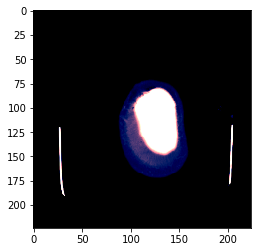

In [20]:
import matplotlib.pyplot as plt
x,y = traingen[0]
plt.imshow(x[-1])